# Imports

In [9]:
import pandas as pd
import numpy as np

#visualization
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

In [ ]:
# ktoś z Was ma lepszy pomysł jak ładować datasets bardziej uniwersalnie? może bezpośrednio z githuba? 

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!ls -la '/content/drive/My Drive/Colab Notebooks/upskill/projekt końcowy'

total 53
drwx------ 2 root root  4096 Mar 25 10:19 datasets
-rw------- 1 root root 49507 Mar 28 12:28 Novozymes_Enzyme_Stability_Prediction.ipynb


In [4]:
%cd /content/drive/My Drive/Colab Notebooks/upskill/projekt końcowy

/content/drive/My Drive/Colab Notebooks/upskill/projekt końcowy


# Loading datasets
There are some data issues in the training data. A file has been added to the Data page which contains the rows that should not be used due to data quality issues (2409 rows, with all features marked as NaN), as well as the rows where the pH and tm were transposed (25 rows, with corrected features in this dataset).

The original train.csv has not been modified, so it is necessary to complete the train dataset during loading.

## Train dataset

In [5]:
df_train = pd.read_csv("datasets/train.csv", index_col="seq_id")
df_train_updates = pd.read_csv("datasets/train_updates_20220929.csv", index_col="seq_id")

all_features_nan = df_train_updates.isnull().all("columns")

drop_indices = df_train_updates[all_features_nan].index
df_train = df_train.drop(index=drop_indices)

swap_ph_tm_indices = df_train_updates[~all_features_nan].index
df_train.loc[swap_ph_tm_indices, ["pH", "tm"]] = df_train_updates.loc[swap_ph_tm_indices, ["pH", "tm"]]

In [6]:
df_train.head()

,protein_sequence,pH,data_source,tm
seq_id,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


## Test dataset

In [7]:
df_test = pd.read_csv("datasets/test.csv", index_col="seq_id")
df_test.head()

,protein_sequence,pH,data_source
seq_id,,,
31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [8]:
df_test_labels = pd.read_csv("datasets/test_labels.csv", index_col="seq_id")
df_test_labels.head()

,tm
seq_id,
31390,77.3
31391,77.3
31392,77.3
31393,76.6
31394,77.4


# Basic information

## Train dataset

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28981 entries, 0 to 31389
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   protein_sequence  28981 non-null  object 
 1   pH                28695 non-null  float64
 2   data_source       28001 non-null  object 
 3   tm                28981 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.1+ MB


In [ ]:
df_train.describe()

,pH,tm
count,28695.000000,28981.000000
mean,6.872467,51.360005
std,0.793184,12.056717
min,1.990000,25.100000
25%,7.000000,43.600000
50%,7.000000,48.800000
75%,7.000000,54.600000
max,11.000000,130.000000


In [ ]:
# missing values

df_train.isnull().sum().sort_values(ascending = False)

data_source         980
pH                  286
protein_sequence      0
tm                    0
dtype: int64

## Test dataset

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2413 entries, 31390 to 33802
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   protein_sequence  2413 non-null   object
 1   pH                2413 non-null   int64 
 2   data_source       2413 non-null   object
dtypes: int64(1), object(2)
memory usage: 75.4+ KB


In [ ]:
df_test.describe()

,pH
count,2413.0
mean,8.0
std,0.0
min,8.0
25%,8.0
50%,8.0
75%,8.0
max,8.0


In [ ]:
# missing values

df_test.isnull().sum().sort_values(ascending = False)

protein_sequence    0
pH                  0
data_source         0
dtype: int64

# Missing values
Missing values ​​are only in train dataset.

*   'data_source' - 980 missing values
*   'pH' - 286 missing values

'data_source' will be not use in modelling so it can contains missing values. 
Column 'pH' is very important and missing values ​​account less than 1% of all values, therefore rows containing missing values ​​in the 'pH' column will be deleted.

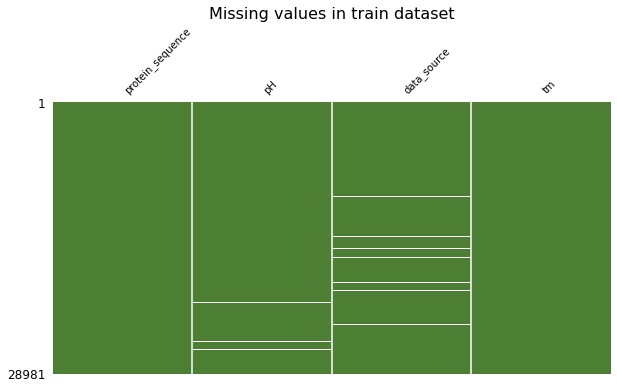

In [ ]:
msno.matrix(df_train, figsize=(10,5), color = (0.3, 0.5, 0.2), fontsize = 10, sparkline = False)
plt.title('Missing values in train dataset', fontdict = {'fontsize':16})
plt.show(); 

In [ ]:
df_train.dropna(subset=['pH'], inplace=True)

In [ ]:
df_train.isnull().sum().sort_values(ascending = False)

data_source         968
protein_sequence      0
pH                    0
tm                    0
dtype: int64

# K-mer counting

In [10]:
# ustawienie wartości k
k = 3

# funkcja do obliczania k-mer counting dla sekwencji białkowej
def get_kmer_counts(seq):
    kmer_counts = Counter()
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        kmer_counts[kmer] += 1
    return kmer_counts

# zastosowanie funkcji get_kmer_counts do każdej sekwencji w kolumnie 'protein_sequence'
kmer_counts = df_train['protein_sequence'].apply(get_kmer_counts)

# zamiana kmer_counts na dataframe z odpowiednią nazwą kolumny
kmer_counts_df = pd.DataFrame.from_records(kmer_counts).fillna(0).astype(int)
kmer_counts_df.columns = [f"kmer_{k}_{kmer}" for kmer in kmer_counts_df.columns]

# połączenie oryginalnego dataframe'u z kmer_counts_df
df = pd.concat([df_train, kmer_counts_df], axis=1)
df

,protein_sequence,pH,data_source,tm,kmer_3_AAA,kmer_3_AAK,kmer_3_AKA,kmer_3_KAA,kmer_3_AAL,kmer_3_ALA,...,kmer_3_CMY,kmer_3_WMH,kmer_3_CWP,kmer_3_MCM,kmer_3_WCC,kmer_3_HMW,kmer_3_WHC,kmer_3_CWW,kmer_3_WKW,kmer_3_WCW
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7,3.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5,4.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28841,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28842,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28845,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28849,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from Bio.SubsMat import MatrixInfo
import numpy as np

# macierz BLOSUM62
blosum62 = MatrixInfo.blosum62

# funkcja do mapowania aminokwasów na wektory liczbowe
def seq_to_vec(sequence):
    # długość wektora to 20, ponieważ istnieje 20 różnych aminokwasów
    vector = np.zeros((20,))
    # iteracja po sekwencji i dodanie wektorów odpowiadających aminokwasom
    for aa in sequence:
        if aa in blosum62:
            vector += np.array(blosum62[aa])
    return vector

# przykładowy dataset
dataset = {
    'protein_sequence': [
        'AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG',
        'AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR',
        'AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA',
        'AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL',
        'AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA'
    ],
    'pH': [7.0, 7.0, 7.0, 7.0, 7.0],
    'data_source': [
        'doi.org/10.1038/s41592-020-0801-4',
        'doi.org/10.1038/s41592-020-0801-4',
        'doi.org/10.1038/s41592-020-0801-4',
        'doi.org/10.1038/s41592-020-0801-4',
        'doi.org/10.1038/s41592-020-0801-4'
    ],
    'tm': [75.7, 50.5, 40.5, 47.2, 49.5]
}

# zastosowanie funkcji seq_to_vec dla każdej sekwencji
embeddings = []
for seq in dataset['protein_sequence']:
    embeddings.append(seq_to_vec(seq))